In [ ]:
!pip install matplotlib

In [ ]:
!pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Importing necessary libraries
import requests
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
# Function to get Facebook page posts
def get_page_posts(page_id, access_token):
    base_url = f"https://graph.facebook.com/v18.0/{page_id}/posts"
    params = {'access_token': access_token, 'fields': 'id,message,comments{message,from}'}
    response = requests.get(base_url, params=params)
    return response.json()



In [ ]:
# Function to extract comments from posts
def extract_comments(post):
    post_id = post.get('id', '')
    comments = post.get('comments', {}).get('data', [])

    extracted_comments = []

    for comment in comments:
        commenter_name = comment.get('from', {}).get('name', 'Unknown User')
        comment_message = comment.get('message', 'No Comment Message')
        comment_id = comment.get('id', 'No Comment ID')

        comment_details = {
            'post_id': post_id,
            'comment_id': comment_id,
            'commenter_name': commenter_name,
            'comment_message': comment_message
        }

        extracted_comments.append(comment_details)

    return extracted_comments

In [ ]:
# Function to post a reply to a comment
def post_comment_reply(comment_id, message, access_token):
    base_url = f"https://graph.facebook.com/v18.0/{comment_id}/comments"
    params = {'message': message, 'access_token': access_token}
    response = requests.post(base_url, params=params)
    return response.json()


In [ ]:
# Function to initialize sentiment distribution values
def initialize_sentiment_distribution():
    return {
        "Positive High": 0,
        "Positive Medium": 0,
        "Negative High": 0,
        "Negative Medium": 0,
        "Neutral": 0,
    }

In [ ]:
# Function to initialize sentiment reply data
def initialize_reply_data():
    return {
    "positive_high": "We're thrilled to hear that you had such a positive experience! Thank you for your kind words!",
    "positive_medium": "Thank you for your positive comment! We appreciate your feedback!",
    "negative_high": "We're sorry to hear that you're not satisfied. Our team will look into this issue as soon as possible.",
    "negative_medium": "We appreciate your feedback, and we're sorry for any inconvenience caused. Please let us know how we can improve.",
    "neutral": "Thanks for your comment! Your feedback is very important to us."
    }

In [ ]:
# Function to perform sentinment analysis and choose replies accordingly
def perform_sentiment_analysis(comments, replied_comments, reply_data, sentiment_distribution, sid, access_token):
    for comment_details in comments:
        comment_id = comment_details['comment_id']

        # Skip if already replied to this comment
        if comment_id in replied_comments:
            continue

        commenter_name = comment_details['commenter_name']

        # Check case, to avoid replying to myself (page account)
        if commenter_name != 'Jaeger':

            comment_message = comment_details['comment_message']
            sentiment_score = sid.polarity_scores(comment_message)['compound']

            if sentiment_score > 0.5:
                reply = reply_data['positive_high']
                sentiment_distribution["Positive High"] += 1
            elif sentiment_score > 0.2:
                reply = reply_data['positive_medium']
                sentiment_distribution["Positive Medium"] += 1
            elif sentiment_score < -0.5:
                reply = reply_data['negative_high']
                sentiment_distribution["Negative High"] += 1
            elif sentiment_score < -0.2:
                reply = reply_data['negative_medium']
                sentiment_distribution["Negative Medium"] += 1
            else:
                reply = reply_data['neutral']
                sentiment_distribution["Neutral"] += 1

            print(f"Post ID: {comment_details['post_id']}")
            print(f"Comment ID: {comment_details['comment_id']}")
            print(f"Commenter: {comment_details['commenter_name']}")
            print(f"Comment: {comment_details['comment_message']}")
            print(f"Sentiment Score: {sentiment_score}")
            print(f"Reply: {reply}")

            # posting comment reply using the designated function
            response = post_comment_reply(comment_id, reply, access_token)

            # Real time update to check execution
            if 'id' in response:
                replied_comments.add(comment_id)
                print("Reply successfully posted.")
            else:
                print("Failed to post reply. Please check and try again.")

            print('-' * 50)


In [ ]:
def plot_pie_chart(sentiment_distribution):
    labels = sentiment_distribution.keys()
    sizes = sentiment_distribution.values()

    #Handling Value Error
    zero_count = list(sentiment_distribution.values()).count(0)

    if zero_count != len(sentiment_distribution):
        plt.title("Overall sentiment distribution of comments for all posts made")
        plt.pie(x=sizes, labels=None, autopct=lambda p: f'{p:.1f}%' if p > 0 else '', startangle=90)
        plt.legend(labels, loc="best", bbox_to_anchor=(1, 1))
    else:
      return ("Empty data")


In [ ]:
# Initializion for Sentiment analysis
reply_data =  initialize_reply_data()
sentiment_distribution = initialize_sentiment_distribution()
sid = SentimentIntensityAnalyzer()

In [ ]:
#file paths
facebook_data_path = f"/content/drive/My Drive/aim_t1/facebook_data.json"
replied_comments_path = f"/content/drive/My Drive/aim_t1/replied_comments2.txt"

In [ ]:
# Intializing access token and page id
#-----------------------------------------
# These credentials are feteched using Facebook Developers App
# by the help of GRAPH API
# ** I removed mine for privacy reasons, but the code works! **

access_token = "xxxxxxxxx" # Enter your access token
page_id = "xxxxxxxxx" # Enter your page id

In [ ]:
# Load already replied comments from a file (if exists)
replied_comments = set()
try:
    with open(replied_comments_path, "r") as file:
        replied_comments = set(file.read().splitlines())
except FileNotFoundError:
    replied_comments = set()

# Getting posts from the Facebook page
json_data = get_page_posts(page_id, access_token)

# Writing the received json response to a text file
with open(facebook_data_path, "w", encoding="utf-8") as file:
    json.dump(json_data, file, ensure_ascii=False, indent=2)


# Extracting comments from each post and perform sentiment analysis with VADER
for post in json_data.get('data', []):  # if data doesn't exist empty array will be returned
    comments = extract_comments(post)

    perform_sentiment_analysis(comments, replied_comments, reply_data, sentiment_distribution, sid, access_token)

# Saving replied comments to file after the entire script execution
with open(replied_comments_path, "w") as file:
    file.write("\n".join(replied_comments))


Post ID: 140935059114006_122097283094158880
Comment ID: 122097283094158880_680686090911146
Commenter: Ishraq Nur
Comment: Not good enough
Sentiment Score: -0.3412
Reply: We appreciate your feedback, and we're sorry for any inconvenience caused. Please let us know how we can improve.
Reply successfully posted.
--------------------------------------------------
Post ID: 140935059114006_122097283094158880
Comment ID: 122097283094158880_375651791514018
Commenter: Ishraq Nur
Comment: Needs more work
Sentiment Score: 0.0
Reply: Thanks for your comment! Your feedback is very important to us.
Reply successfully posted.
--------------------------------------------------
Post ID: 140935059114006_122097283094158880
Comment ID: 122097283094158880_1098758298151900
Commenter: Ishraq Nur
Comment: Best product
Sentiment Score: 0.6369
Reply: We're thrilled to hear that you had such a positive experience! Thank you for your kind words!
Reply successfully posted.
-----------------------------------------

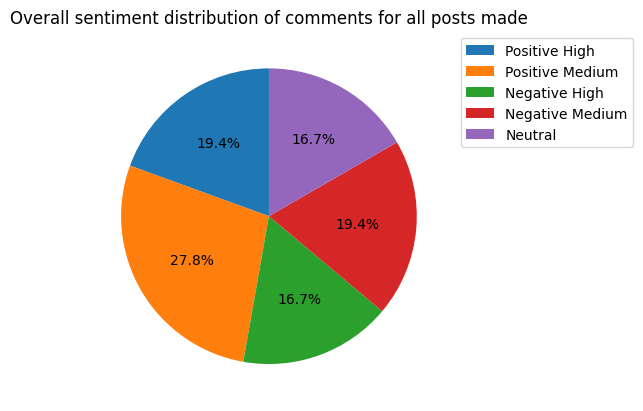

In [ ]:
# Simple bar chart to show sentiment distribution
plot_pie_chart(sentiment_distribution)